# This notebook does the following:
## 1. Read the MC DL2 files of at least point-like gamma
## 2. Use the config to apply the cuts and bin various parameters for the IRFs
## 3. Using pyirf functions, generate IRFs
## 4. Check with some basic plots of the IRFs

In [1]:
%matplotlib inline
import numpy as np
from pathlib import Path

from astropy.io import fits
import astropy.units as u
from astropy.table import QTable, vstack

import matplotlib.pyplot as plt
from traitlets.config.loader import Config

In [2]:
from pyirf.io.gadf import (
    create_aeff2d_hdu,
    create_energy_dispersion_hdu,
    create_background_2d_hdu,
    create_psf_table_hdu,
)
from pyirf.irf import (
    effective_area_per_energy,
    energy_dispersion,
    effective_area_per_energy_and_fov,
    background_2d,
    psf_table,
)
from pyirf.spectral import (
    calculate_event_weights,
    PowerLaw,
    CRAB_MAGIC_JHEAP2015,
    IRFDOC_PROTON_SPECTRUM,
    IRFDOC_ELECTRON_SPECTRUM,
)
from pyirf.utils import calculate_source_fov_offset, calculate_theta

from gammapy.irf import EnergyDispersion2D, EffectiveAreaTable2D, Background2D, PSF3D

In [3]:
from lstchain.io.io import read_mc_dl2_to_QTable
from lstchain.io.event_selection import EventSelector, DL3FixedCuts, DataBinning
from lstchain.io.config import read_configuration_file

# 1. Input parameters to convert MC DL2 files to IRF

In [4]:
mc_base_dir = "/fefs/aswg/data/mc/DL2/20200629_prod5_trans_80/"
# Using the same zenith, azimuth pointing and the production version to generate the IRF
mc_pnt_n_prod = "/zenith_20deg/south_pointing/20210416_v0.7.3_prod5_trans_80_local_taicut_8_4/"

# DL2 file paths for each particle
gamma_dl2 = mc_base_dir + "gamma" + mc_pnt_n_prod + "off0.4deg/dl2_gamma_20deg_180deg_off0.4deg_20210416_v0.7.3_prod5_trans_80_local_taicut_8_4_testing.h5"
gamma_diffuse_dl2 = mc_base_dir + "gamma-diffuse" + mc_pnt_n_prod + "dl2_gamma-diffuse_20deg_180deg_20210416_v0.7.3_prod5_trans_80_local_taicut_8_4_testing.h5"
proton_dl2 = mc_base_dir + "proton" + mc_pnt_n_prod + "dl2_proton_20deg_180deg_20210416_v0.7.3_prod5_trans_80_local_taicut_8_4_testing.h5"
electron_dl2 = mc_base_dir + "electron" + mc_pnt_n_prod + "dl2_electron_20deg_180deg_20210416_v0.7.3_prod5_trans_80_local_taicut_8_4_testing.h5"

output_irf_path = "./DL3/"
Path(output_irf_path).mkdir(exist_ok=True)

output_irf_file = "fe_irf_pnt_gamma.fits.gz"

config_file = output_irf_path + "irf_tool_config.json"
point_like =False
overwrite=True

# 2. Collect the information of MC DL2 files

In [5]:
# Create a dict of information for the MC DL2 files of various particles
mc_particle = {
    "gamma": {
        "file": gamma_dl2, #gamma_diffuse_dl2
        "target_spectrum": CRAB_MAGIC_JHEAP2015,
    },
    "proton": {
        "file": proton_dl2,
        "target_spectrum": IRFDOC_PROTON_SPECTRUM,
    },
    "electron": {
        "file": electron_dl2,
        "target_spectrum": IRFDOC_ELECTRON_SPECTRUM,
    },
}


In [6]:
%%time
# Enter more details for each particle
for particle_type, p in mc_particle.items():
    p["events"], p["simulation_info"], p["geomag_params"] = read_mc_dl2_to_QTable(p["file"])

    if p["simulation_info"].viewcone.value == 0.0:
        p["mc_type"] = "point_like"
    else:
        p["mc_type"] = "diffuse"

    # Calculating event weights for Background IRF
    if particle_type != "gamma":
        p["simulated_spectrum"] = PowerLaw.from_simulation(
            p["simulation_info"], 50 * u.hr
        )

        p["events"]["weight"] = calculate_event_weights(
            p["events"]["true_energy"],
            p["target_spectrum"],
            p["simulated_spectrum"],
        )
        
    # Calculate some offset columns
    for prefix in ("true", "reco"):
        k = f"{prefix}_source_fov_offset"
        p["events"][k] = calculate_source_fov_offset(p["events"], prefix=prefix)
        
        # calculate theta / distance between reco and assumed source position
        p["events"]["theta"] = calculate_theta(
            p["events"],
            assumed_source_az=p["events"]["true_az"],
            assumed_source_alt=p["events"]["true_alt"],
        )
    
    # Add the pointing parameters for IRF interpolation
    p["ZEN_PNT"] = round(
       90 - p["events"]["pointing_alt"][0].to_value(u.deg), 2
    )
    p["AZ_PNT"] = round(
        p["events"]["pointing_az"][0].to_value(u.deg), 2
    )

CPU times: user 4.57 s, sys: 2.6 s, total: 7.17 s
Wall time: 7.17 s


# 3. Apply selection cuts and bin the events as per the config file

In [7]:
config = Config(read_configuration_file(config_file))
config

{'EventSelector': {'filters': {'intensity': [0, inf],
   'width': [0, inf],
   'length': [0, inf],
   'r': [0, 1],
   'wl': [0.1, 1],
   'leakage_intensity_width_2': [0, 1],
   'event_type': [32, 33]}},
 'DL3FixedCuts': {'fixed_gh_cut': 0.7,
  'fixed_gh_max_efficiency': 0.9,
  'fixed_theta_cut': 0.2,
  'allowed_tels': [1]},
 'DataBinning': {'true_energy_min': 0.01,
  'true_energy_max': 100,
  'true_energy_n_bins_per_decade': 5.5,
  'reco_energy_min': 0.01,
  'reco_energy_max': 100,
  'reco_energy_n_bins_per_decade': 5.5,
  'energy_migration_min': 0.2,
  'energy_migration_max': 5,
  'energy_migration_n_bins': 31,
  'fov_offset_min': 0.1,
  'fov_offset_max': 1.1,
  'fov_offset_n_edges': 9,
  'bkg_fov_offset_min': 0,
  'bkg_fov_offset_max': 10,
  'bkg_fov_offset_n_edges': 21,
  'source_offset_min': 0.0001,
  'source_offset_max': 1.0001,
  'source_offset_n_edges': 1000}}

In [8]:
gammas = mc_particle["gamma"]["events"]

background = vstack(
    [
        mc_particle["proton"]["events"],
        mc_particle["electron"]["events"]
    ]
)

In [9]:
data_bin = DataBinning(config=Config(config))
event_sel = EventSelector(config=Config(config))
fixed_cuts = DL3FixedCuts(config=Config(config))

In [10]:
%%time
# Binning of parameters used in IRFs
true_energy_bins = data_bin.true_energy_bins()
reco_energy_bins = data_bin.reco_energy_bins()
migration_bins = data_bin.energy_migration_bins()
source_offset_bins = data_bin.source_offset_bins()

mean_fov_offset = round(
    gammas["true_source_fov_offset"].mean().to_value(), 1
)

CPU times: user 3.37 ms, sys: 1.27 ms, total: 4.64 ms
Wall time: 3.68 ms


In [11]:
%%time
# Filter events

print("Size of the gamma table before the filter -",len(gammas))
print("Size of the background table before the filter -",len(background))

gammas = event_sel.filter_cut(gammas)
gammas = fixed_cuts.allowed_tels_filter(gammas)

background = fixed_cuts.allowed_tels_filter(background)
background = event_sel.filter_cut(background)

print("Size of the gamma table after the filter -", len(gammas))
print("Size of the background table after the filter -",len(background))

Size of the gamma table before the filter - 810639
Size of the background table before the filter - 1153590
Size of the gamma table after the filter - 801388
Size of the background table after the filter - 1142843
CPU times: user 1.33 s, sys: 1.65 s, total: 2.99 s
Wall time: 2.94 s


In [12]:
%%time
# Apply the gammaness and theta cut

print("Size of the gamma table before the gammaness cut -",len(gammas))
print("Size of the background table before the gammaness cut -",len(background))

gammas = fixed_cuts.gh_cut(gammas)
background = fixed_cuts.gh_cut(background)

print("Size of the gamma table after the gammaness cut -",len(gammas))
print("Size of the background table after the gammaness cut -",len(background))

if point_like:
    gammas = fixed_cuts.theta_cut(gammas)
    print("Size of the gamma table after the theta cut -",len(gammas))

Size of the gamma table before the gammaness cut - 801388
Size of the background table before the gammaness cut - 1142843
Size of the gamma table after the gammaness cut - 169850
Size of the background table after the gammaness cut - 143165
CPU times: user 448 ms, sys: 46.6 ms, total: 494 ms
Wall time: 489 ms


In [13]:
# Get the FoV Offset bins as per the IRF type
if mc_particle["gamma"]["mc_type"] == "point_like":
    mean_fov_offset = round(
        gammas["true_source_fov_offset"].mean().to_value(), 1
    )
    fov_offset_bins = [
        mean_fov_offset - 0.1, mean_fov_offset + 0.1
    ] * u.deg
    mc_particle["gamma"]["G_OFFSET"] = mean_fov_offset
    mc_particle["gamma"]["ZEN_PNT"] -= mc_particle["gamma"]["G_OFFSET"]
else:
    fov_offset_bins = data_bin.fov_offset_bins()

background_offset_bins = data_bin.bkg_fov_offset_bins()

# 4. Get the extra header values for the final HDUs

In [14]:
extra_headers = {
    "TELESCOP": "CTA-N",
    "INSTRUME": "LST-" + " ".join(map(str, fixed_cuts.allowed_tels)),
    "FOVALIGN": "RADEC",
}

extra_headers["ZEN_PNT"] = str(mc_particle["gamma"]["ZEN_PNT"] * u.deg)
extra_headers["AZ_PNT"] = str(mc_particle["gamma"]["AZ_PNT"] * u.deg)
extra_headers["G_OFFSET"] = str(mean_fov_offset * u.deg)
extra_headers["B_TOTAL"] = str(
    mc_particle["gamma"]["geomag_params"]["GEOMAG_TOTAL"].to(u.uT)
)
extra_headers["B_INC"] = str(
    mc_particle["gamma"]["geomag_params"]["GEOMAG_INC"].to(u.rad)
    )
extra_headers["B_DEC"] = str(
    mc_particle["gamma"]["geomag_params"]["GEOMAG_DEC"].to(u.rad)
)
extra_headers["B_DELTA"] = str(
    mc_particle["gamma"]["geomag_params"]["GEOMAG_DELTA"].to(u.deg)
)

extra_headers["GH_CUT"] = fixed_cuts.fixed_gh_cut

if point_like:
    extra_headers["RAD_MAX"] = str(fixed_cuts.fixed_theta_cut * u.deg)

# 5. Write the HDUs and enter it to the HDUList

In [15]:
hdus = [fits.PrimaryHDU(), ]

In [16]:
%%time
# Effective Area IRF, based on gamma MC type
with np.errstate(invalid="ignore", divide="ignore"):
    if mc_particle["gamma"]["mc_type"] == "point_like":
        effective_area = effective_area_per_energy(
            gammas,
            mc_particle["gamma"]["simulation_info"],
            true_energy_bins=true_energy_bins,
        )
        hdus.append(
            create_aeff2d_hdu(
                # add one dimension for single FOV offset
                effective_area=effective_area[..., np.newaxis],
                true_energy_bins=true_energy_bins,
                fov_offset_bins=fov_offset_bins,
                point_like=point_like,
                extname="EFFECTIVE AREA",
                **extra_headers,
            )
        )
    else:
        effective_area = effective_area_per_energy_and_fov(
            gammas,
            mc_particle["gamma"]["simulation_info"],
            true_energy_bins=true_energy_bins,
            fov_offset_bins=fov_offset_bins,
        )
        hdus.append(
            create_aeff2d_hdu(
                effective_area=effective_area,
                true_energy_bins=true_energy_bins,
                fov_offset_bins=fov_offset_bins,
                point_like=point_like,
                extname="EFFECTIVE AREA",
                **extra_headers,
            )
        )

CPU times: user 35.2 ms, sys: 3.17 ms, total: 38.4 ms
Wall time: 36 ms


In [17]:
%%time
# Energy Dispersion IRF
edisp = energy_dispersion(
    gammas,
    true_energy_bins=true_energy_bins,
    fov_offset_bins=fov_offset_bins,
    migration_bins=migration_bins,
)
hdus.append(
    create_energy_dispersion_hdu(
        edisp,
        true_energy_bins=true_energy_bins,
        migration_bins=migration_bins,
        fov_offset_bins=fov_offset_bins,
        point_like=point_like,
        extname="ENERGY DISPERSION",
        **extra_headers,
    )
)

CPU times: user 31.5 ms, sys: 3.38 ms, total: 34.9 ms
Wall time: 31.9 ms


In [18]:
%%time
# Background IRF
background = background_2d(
    background,
    reco_energy_bins=reco_energy_bins,
    fov_offset_bins=background_offset_bins,
    t_obs=50*u.hr,
)
hdus.append(
    create_background_2d_hdu(
        background.T,
        reco_energy_bins=reco_energy_bins,
        fov_offset_bins=background_offset_bins,
        extname="BACKGROUND",
        **extra_headers,
    )
)

CPU times: user 27.1 ms, sys: 7.2 ms, total: 34.3 ms
Wall time: 30.9 ms


In [19]:
%%time
# PSF Table IRF if point-like IRF
if not point_like:
    psf = psf_table(
        gammas,
        true_energy_bins,
        fov_offset_bins=fov_offset_bins,
        source_offset_bins=source_offset_bins,
    )
    hdus.append(
        create_psf_table_hdu(
            psf,
            true_energy_bins=true_energy_bins,
            source_offset_bins=source_offset_bins,
            fov_offset_bins=fov_offset_bins,
            extname="PSF",
            **extra_headers,
        )
    )

CPU times: user 39.9 ms, sys: 3.02 ms, total: 43 ms
Wall time: 39.3 ms


# 6. Write the HDUList to the final IRF file

In [20]:
fits.HDUList(hdus).writeto(
    output_irf_path + output_irf_file, overwrite=overwrite
)

# 7. Check the IRFs with some basic plots with gammapy

In [21]:
aeff_plot = EffectiveAreaTable2D.read(output_irf_path + output_irf_file, hdu="EFFECTIVE AREA")
edisp_plot = EnergyDispersion2D.read(output_irf_path + output_irf_file, hdu="ENERGY DISPERSION")
bkg_plot = Background2D.read(output_irf_path + output_irf_file, hdu="BACKGROUND")

if not point_like:
    psf_plot = PSF3D.read(output_irf_path + output_irf_file, hdu="PSF")

Text(0.5, 1.0, 'Effective Area')

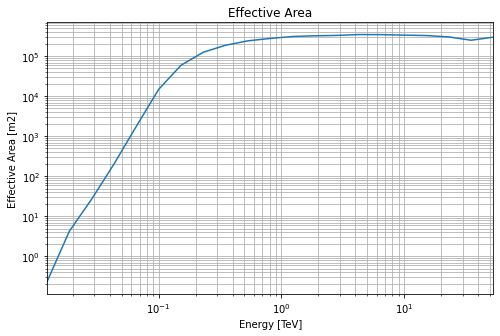

In [22]:
# Effective Area energy dependence
plt.figure(figsize=(8,5))

aeff_plot.plot_energy_dependence(offset=[0.4 * u.deg])
plt.legend().remove()
plt.yscale('log')
plt.grid(which='both')
plt.title("Effective Area")

/home/chaitanya.priyadarsh/anaconda3/envs/lst-dev/lib/python3.8/site-packages/gammapy/irf/effective_area.py:536: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  caxes = ax.pcolormesh(energy.value, offset.value, aeff.value.T, **kwargs)


Text(0.5, 1.0, 'Effective Area - energy offset dependence')

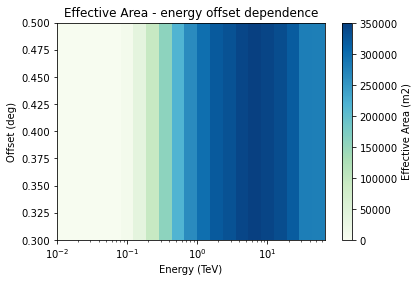

In [23]:
# Energy Offset dependence
aeff_plot.plot()
plt.title("Effective Area - energy offset dependence")

In [24]:
# Effective Area offset dependence when diffuse gamma is used
if not mc_particle["gamma"]["mc_type"] == "point_like":
    aeff_plot.plot_offset_dependence()

Text(0.5, 0.98, 'Energy migration')

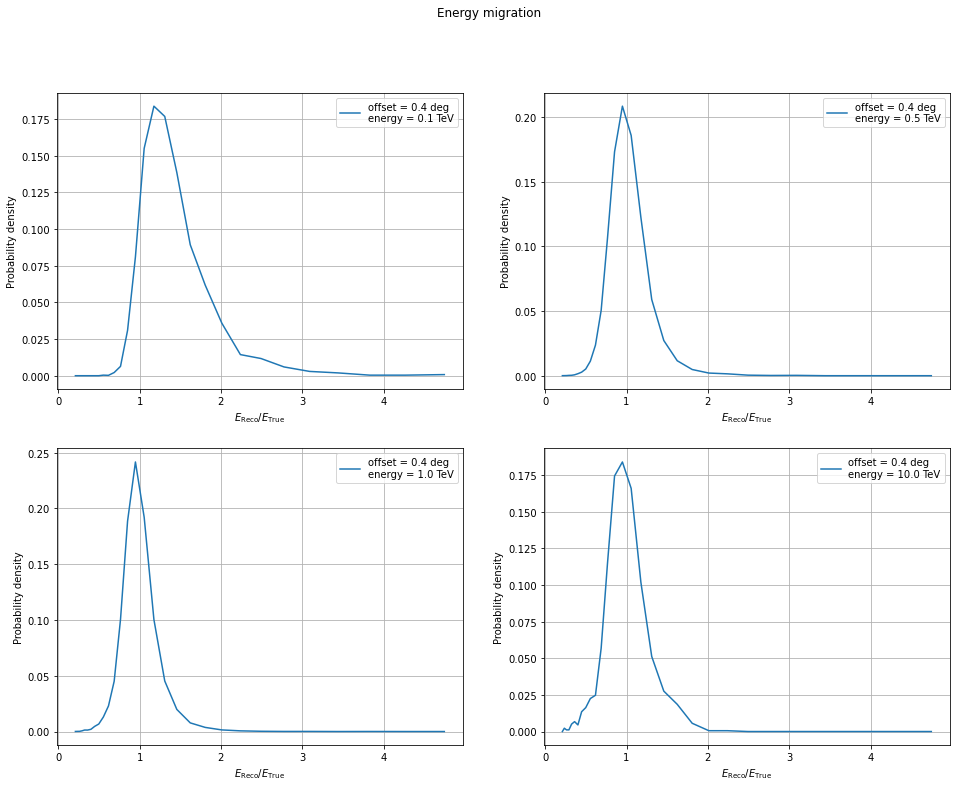

In [25]:
# Energy Dispersion, energy migratoin
plt.figure(figsize=(16,12))

offset = "0.4 deg"
true_energy = [0.1, 0.5, 1, 10] * u.TeV

plt.subplot(221)
edisp_plot.plot_migration(offset=offset, energy_true=true_energy[0])
plt.legend(loc=1)
plt.grid()

plt.subplot(222)
edisp_plot.plot_migration(offset=offset, energy_true=true_energy[1])
plt.legend(loc=1)
plt.grid()

plt.subplot(223)
edisp_plot.plot_migration(offset=offset, energy_true=true_energy[2])
plt.legend(loc=1)
plt.grid()

plt.subplot(224)
edisp_plot.plot_migration(offset=offset, energy_true=true_energy[3])
plt.legend(loc=1)
plt.grid()

plt.suptitle("Energy migration")

Text(0.5, 1.0, 'Energy Bias at 0.4 deg')

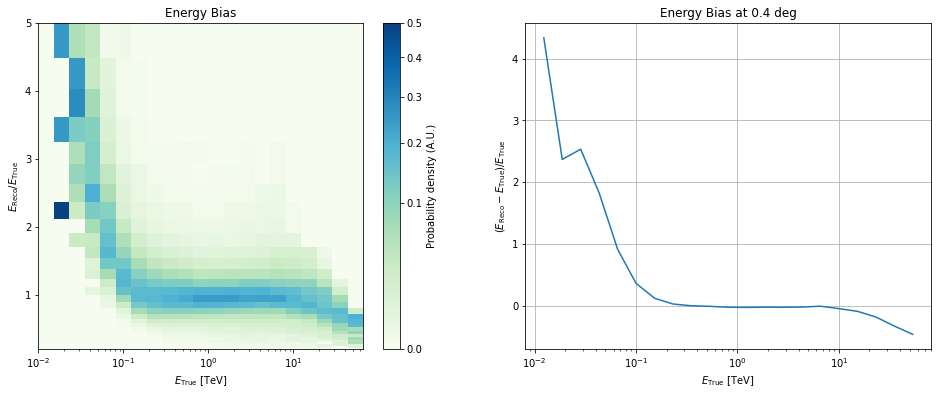

In [26]:
# Energy bias

plt.figure(figsize=(16,6))

plt.subplot(121)
edisp_plot.plot_bias(offset=offset, add_cbar=True)
plt.title("Energy Bias")

plt.subplot(122)
edisp_kernel = edisp_plot.to_edisp_kernel(offset=0.4*u.deg)
edisp_kernel.plot_bias()
plt.grid()
plt.title("Energy Bias at 0.4 deg")

Text(0.5, 1.0, 'Energy Migration Matrix')

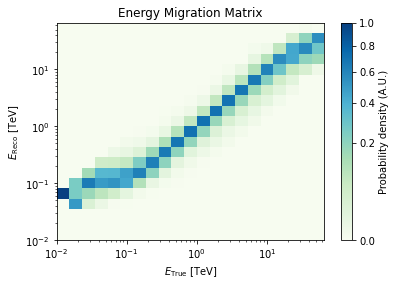

In [27]:
# Energy migration matrix
edisp_kernel.plot_matrix(add_cbar=True)
plt.title("Energy Migration Matrix")

Text(0.5, 1.0, 'Background rate - offset dependence')

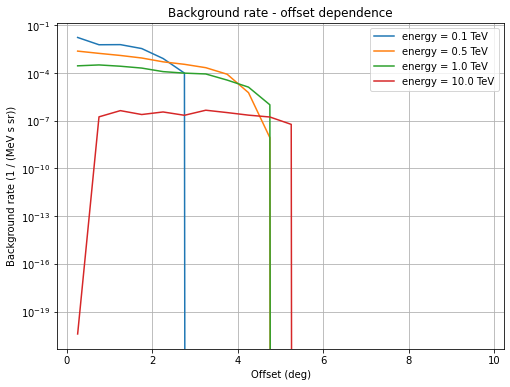

In [28]:
# Background, offset dependence
plt.figure(figsize=(8,6))

bkg_plot.plot_offset_dependence(energy=true_energy)
plt.grid(which="both")
plt.title("Background rate - offset dependence")

/home/chaitanya.priyadarsh/anaconda3/envs/lst-dev/lib/python3.8/site-packages/astropy/units/quantity.py:486: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/chaitanya.priyadarsh/anaconda3/envs/lst-dev/lib/python3.8/site-packages/astropy/units/quantity.py:486: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Text(0.5, 0.98, 'Background rate - energy dependence')

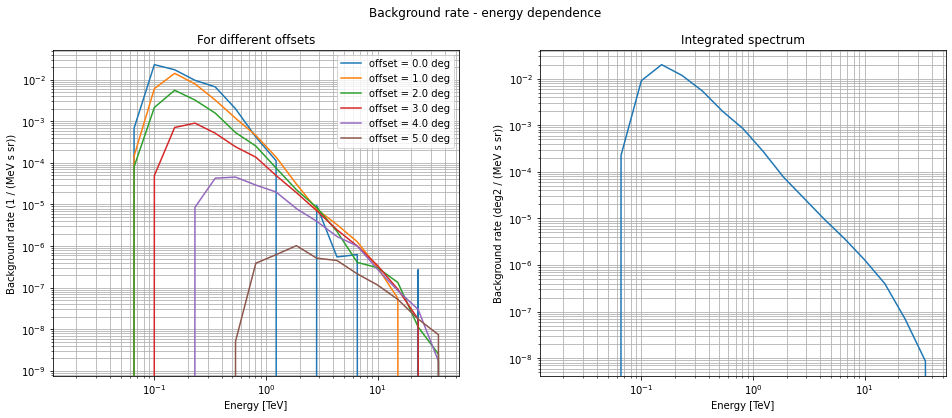

In [29]:
# Background rate energy dependence
plt.figure(figsize=(16,6))
bkg_offset = [0, 1, 2, 3, 4, 5] * u.deg

plt.subplot(121)

labels = []
for o in bkg_offset:
    bkg_plot.plot_energy_dependence(offset=[o])
    labels.append(f"offset = {o}")
plt.legend().remove()
plt.legend(labels)
plt.grid(which="both")
plt.title("For different offsets")

plt.subplot(122)
bkg_plot.plot_spectrum()
plt.grid(which="both")
plt.legend().remove()
plt.title("Integrated spectrum")

plt.suptitle("Background rate - energy dependence")

Text(0.5, 1.0, 'Background rate - energy offset dependence')

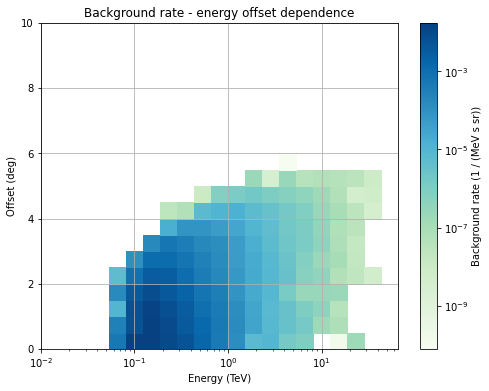

In [30]:
# Energy offset dependence
plt.figure(figsize=(8,6))
bkg_plot.plot()
plt.grid()
plt.title("Background rate - energy offset dependence")